# Preprocessing data

In [21]:
# importando bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

## Visualization

In [22]:
# carregando base de dados de treinamento
EFPg_train = np.load("../../../Data/DataJetTagging/Trainning/g_jets_efps_d5_primed.npy")
EFPq_train = np.load("../../../Data/DataJetTagging/Trainning/q_jets_efps_d5_primed.npy")
EFPt_train = np.load("../../../Data/DataJetTagging/Trainning/t_jets_efps_d5_primed.npy")

In [48]:
column_index = 30 # escolhendo o índice da coluna

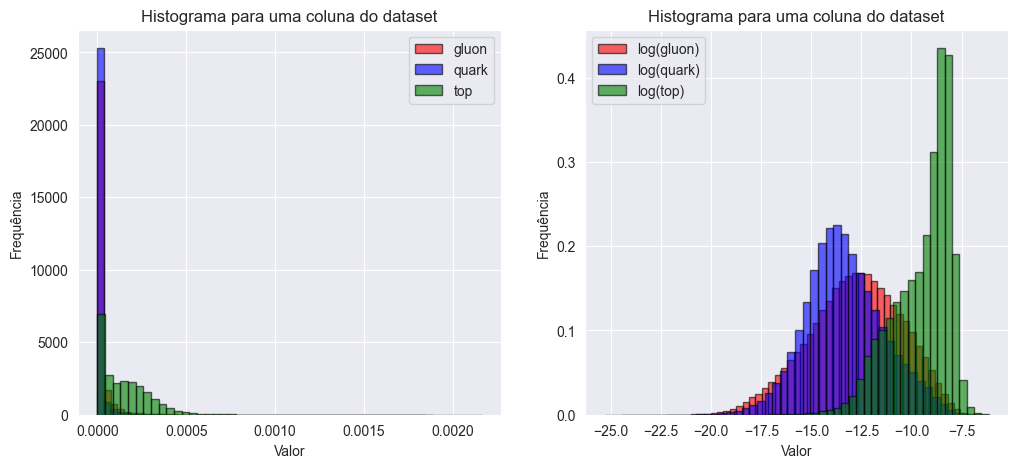

In [49]:
data_g = EFPg_train[:, column_index] # valores da coluna
data_log_g = np.log(data_g) # logarithmic-scaling

data_q = EFPq_train[:, column_index] # valores da coluna
data_log_q = np.log(data_q) # logarithmic-scaling

data_t = EFPt_train[:, column_index] # valores da coluna
data_log_t = np.log(data_t) # logarithmic-scaling

nbins = 50 # número de bins no histograma

fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})
fig.subplots_adjust(wspace=0.2)

# histograma - sem normalizar
axes[0].hist(data_g, bins=nbins, density=True, alpha=0.6, color='r', edgecolor='black', label='gluon')
axes[0].hist(data_q, bins=nbins, density=True, alpha=0.6, color='b', edgecolor='black', label='quark')
axes[0].hist(data_t, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black', label='top')
axes[0].set_ylabel("Frequência")
axes[0].set_xlabel("Valor")
axes[0].set_title(f'Histograma para uma coluna do dataset')
axes[0].legend()

# histograma - normalizando
axes[1].hist(data_log_g, bins=nbins, density=True, alpha=0.6, color='r', edgecolor='black', label='log(gluon)')
axes[1].hist(data_log_q, bins=nbins, density=True, alpha=0.6, color='b', edgecolor='black', label='log(quark)')
axes[1].hist(data_log_t, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black', label='log(top)')
axes[1].set_ylabel("Frequência")
axes[1].set_xlabel("Valor")
axes[1].set_title(f'Histograma para uma coluna do dataset')
axes[1].legend()

# plt.savefig('histograms.png', dpi=300)  # Save as PNG with high resolution

plt.show()

# Dimensionality reduction

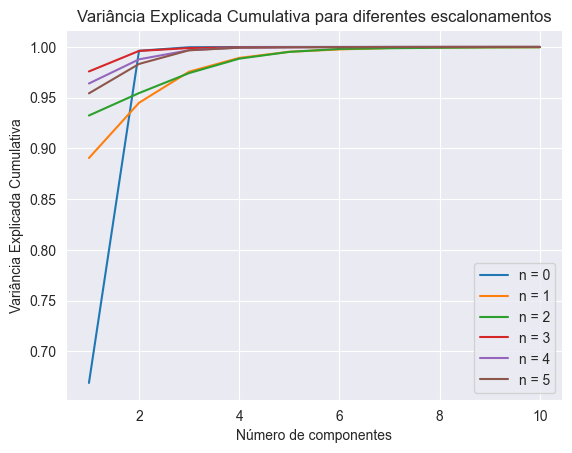

In [45]:
from src.Preprocessing.norm import norm

for n in range(0, 6):

    # conjuntos onde vamos aplicar o PCA:
    X = np.concatenate((X_train, X_val, X_test), axis=0)
    X = norm(n, X)

    pca = PCA()
    pca.fit(X)
    explainability = pca.explained_variance_ratio_.cumsum()
    factors = range(1,len(pca.explained_variance_ratio_)+1)
    plt.plot(factors[:10], explainability[:10], label=f'n = {n}')
    
# plt.hlines(0.9,0,20,'r')
plt.xlabel('Número de componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Variância Explicada Cumulativa para diferentes escalonamentos')
plt.legend()
plt.grid(True)

plt.savefig('PCA.png', dpi=300) 

plt.show()
# print('Explicabilidade da primeira componente principal (PC1):', explainability[0].round(3))
# print('Explicabilidade da segunda componente principal (PC2):', explainability[1].round(3))

In [11]:
# # coeficientes da PC1
# pca.components_[0]

In [12]:
# # coeficientes da PC2
# pca.components_[1]

In [13]:
# X_pca = pca.transform(X) # variáveis preditoras no espaço das PCs
# N = 20 # número de PCs que vamos pegar
# X_pca = X_pca[:,:N] # pegando as N primeiras PCs

In [14]:
# # executar essa célula para rodar o modelo utilizando apenas as PCs
# X_train, X_val, X_test = X_pca[:len(X_train)], X_pca[len(X_train):len(X_train)+len(X_val)], X_pca[len(X_train)+len(X_val):]

# Model

In [59]:
import joblib

model = joblib.load("LinearDiscriminant_top_n0.joblib")

Intercept: -10.689131844834973


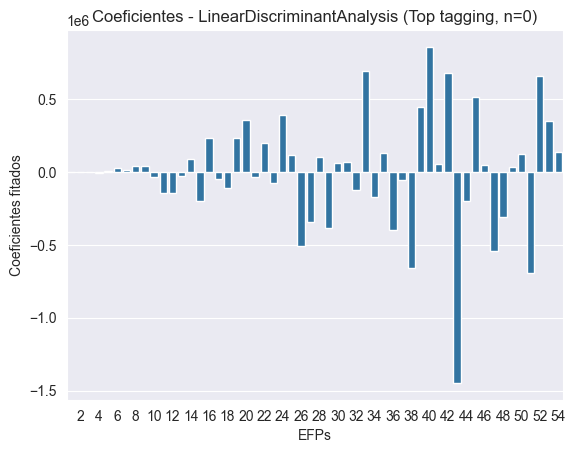

In [60]:
# NÃO EXECUTAR ESSA CÉLULA SE 0 MODELO NÃO POSSUIR intercept_ OU coef_

# intercept
print('Intercept:', model.intercept_[0])

# weights
coef = model.coef_[0]
sns.barplot (x=np.arange(1, len(coef)+1), y=coef)
plt.xlabel("EFPs")
plt.ylabel("Coeficientes fitados")
plt.title("Coeficientes - LinearDiscriminantAnalysis (Top tagging, n=0)");

# Adjust x-axis ticks
n = 2  # Display every n-th element
plt.xticks(np.arange(1, len(coef)+1, n))

plt.savefig('coef_LDA_top_n0.png', dpi=300) 

plt.show()

In [61]:
# pega a posição dos três maiores coeficientes em módulo
np.argsort(np.abs(coef))[::-1][:3]

array([42, 39, 32], dtype=int64)

# Performance metrics

In [16]:
from ML.EFPs.split import split
from src.Preprocessing.norm import norm

def performance_metrics(tagging, n, set, model):
    #check the possible input parameters on the next cell
    
    # Partitioning and Splitting
    X_train, X_val, X_test, y_train, y_val, y_test = split(tagging)
    
    # convertendo y de arrays para dataframes
    y_train = y_train.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    
    # Normalization
    X_train, X_val, X_test = norm(n,X_train), norm(n,X_val), norm(n,X_test)
    
    # escolhendo qual conjunto vamos avaliar
    if set == "train":
        X_set, y_set = X_train, y_train
    elif set== "val":
        X_set, y_set = X_val, y_val
    else: # set == "test"
        X_set, y_set = X_test, y_test
    
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_set)
    # Classification Report
#    print('Classification Report:\n',metrics.classification_report(y_set.ravel(), y_pred, digits=3))
    
    # Confusion Matrix
#    print('Confusion Matrix:\n',metrics.confusion_matrix(y_set.ravel(), y_pred, normalize='all').round(2))
    
    y_predproba = model.predict_proba(X_set)[:, -1]
    # ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_set.ravel(), y_predproba)
    roc_auc = metrics.roc_auc_score(y_set.ravel(), y_predproba)
#    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
#    display.plot()
#    plt.plot([0,1],[0,1],'r--')
#    plt.show()
    return metrics.accuracy_score(y_set.ravel(), y_pred), roc_auc

In [17]:
# parameter ranges
tagging_values = ["top", "qg"]
n_values = [0, 1, 2, 3, 4, 5]
set_values = ["train", "val", "test"]
model_values = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(tol=1.0e-6)]

In [18]:
import itertools

# combinations of parameters
param_combinations = list(itertools.product(tagging_values, n_values, set_values, model_values))

In [19]:
# Loop to execute performance_metrics() with varying parameters
accuracy_AUC = []

for i, (tagging, n, set, model) in enumerate(param_combinations):
    accuracy, AUC = performance_metrics(tagging, n, set, model)
    print(tagging,'---',n,'---',set,'---',model)
    print('accuracy:',round(accuracy,3),', AUC:',AUC.round(3))
    print('=======================================================================')
    accuracy_AUC.append([[tagging, n, set, model],[accuracy,AUC]])

top --- 0 --- train --- LinearDiscriminantAnalysis()
accuracy: 0.884 , AUC: 0.95
top --- 0 --- train --- QuadraticDiscriminantAnalysis(tol=1e-06)
accuracy: 0.809 , AUC: 0.935
top --- 0 --- val --- LinearDiscriminantAnalysis()
accuracy: 0.885 , AUC: 0.951
top --- 0 --- val --- QuadraticDiscriminantAnalysis(tol=1e-06)
accuracy: 0.811 , AUC: 0.936
top --- 0 --- test --- LinearDiscriminantAnalysis()
accuracy: 0.883 , AUC: 0.95
top --- 0 --- test --- QuadraticDiscriminantAnalysis(tol=1e-06)
accuracy: 0.809 , AUC: 0.936
top --- 1 --- train --- LinearDiscriminantAnalysis()
accuracy: 0.884 , AUC: 0.95
top --- 1 --- train --- QuadraticDiscriminantAnalysis(tol=1e-06)
accuracy: 0.809 , AUC: 0.935
top --- 1 --- val --- LinearDiscriminantAnalysis()
accuracy: 0.539 , AUC: 0.328
top --- 1 --- val --- QuadraticDiscriminantAnalysis(tol=1e-06)
accuracy: 0.595 , AUC: 0.602
top --- 1 --- test --- LinearDiscriminantAnalysis()
accuracy: 0.782 , AUC: 0.913
top --- 1 --- test --- QuadraticDiscriminantAnalysis

In [20]:
accuracy_AUC

[[['top', 0, 'train', LinearDiscriminantAnalysis()],
  [0.8838449588012035, 0.9495337507038542]],
 [['top', 0, 'train', QuadraticDiscriminantAnalysis(tol=1e-06)],
  [0.809006705866158, 0.93503328043852]],
 [['top', 0, 'val', LinearDiscriminantAnalysis()],
  [0.8851125473590372, 0.9510731852367876]],
 [['top', 0, 'val', QuadraticDiscriminantAnalysis(tol=1e-06)],
  [0.810786717182973, 0.9362490214304817]],
 [['top', 0, 'test', LinearDiscriminantAnalysis()],
  [0.8834583617488824, 0.9500268056581684]],
 [['top', 0, 'test', QuadraticDiscriminantAnalysis(tol=1e-06)],
  [0.8086307494127454, 0.9358786931098012]],
 [['top', 1, 'train', LinearDiscriminantAnalysis()],
  [0.8838449588012035, 0.9495337507038542]],
 [['top', 1, 'train', QuadraticDiscriminantAnalysis(tol=1e-06)],
  [0.809006705866158, 0.93503328043852]],
 [['top', 1, 'val', LinearDiscriminantAnalysis()],
  [0.5390238466681524, 0.32760799824480613]],
 [['top', 1, 'val', QuadraticDiscriminantAnalysis(tol=1e-06)],
  [0.5948963672832628

In [75]:
accuracy_AUC_top = [item for item in accuracy_AUC if 'top' in item[0]]
accuracy_AUC_qg = [item for item in accuracy_AUC if 'qg' in item[0]]

In [76]:
accuracy_AUC_top_quad = accuracy_AUC_top[1::2]
accuracy_AUC_qg_quad = accuracy_AUC_qg[1::2]
# não precisa definir accuracy_AUC_top_lin e accuracy_AUC_qg_lin porque os melhores já são todos com modelo linear

In [85]:
for set in ['train','val','test']:
    print('Maior acurácia:',max( [item for item in accuracy_AUC_top_quad if set in item[0]] , key=lambda x: x[1][0]))
    print('Maior AUC     :',max( [item for item in accuracy_AUC_top_quad if set in item[0]] , key=lambda x: x[1][1]))

Maior acurácia: [['top', 3, 'train', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.8420404711805077, 0.9244527814831438]]
Maior AUC     : [['top', 0, 'train', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.809006705866158, 0.93503328043852]]
Maior acurácia: [['top', 5, 'val', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.8442166258078895, 0.9263571883736148]]
Maior AUC     : [['top', 0, 'val', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.810786717182973, 0.9362490214304817]]
Maior acurácia: [['top', 5, 'test', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.8441880730469046, 0.9250688932519777]]
Maior AUC     : [['top', 0, 'test', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.8086307494127454, 0.9358786931098012]]


In [86]:
for set in ['train','val','test']:
    print('Maior acurácia:',max( [item for item in accuracy_AUC_qg_quad if set in item[0]] , key=lambda x: x[1][0]))
    print('Maior AUC     :',max( [item for item in accuracy_AUC_qg_quad if set in item[0]] , key=lambda x: x[1][1]))

Maior acurácia: [['qg', 3, 'train', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.7409807501819962, 0.8016795021008634]]
Maior AUC     : [['qg', 0, 'train', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.6194073490625709, 0.8192229382384387]]
Maior acurácia: [['qg', 3, 'val', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.7416707993327623, 0.8028496077436271]]
Maior AUC     : [['qg', 0, 'val', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.6179162346152112, 0.8178657711379664]]
Maior acurácia: [['qg', 5, 'test', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.7402567541674651, 0.7988778293023242]]
Maior AUC     : [['qg', 0, 'test', QuadraticDiscriminantAnalysis(tol=1e-06)], [0.6167273424027592, 0.816078610421954]]


# Saving the models

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from ML.EFPs.split import split
from src.Preprocessing.norm import norm
import joblib

# choosing the model
tagging = "top" # "top", "qg"
n = 5 # 0, 1, 2, 3, 4, 5    
model = QuadraticDiscriminantAnalysis(tol=1.0e-6) # LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(tol=1.0e-6)

# Partitioning and Splitting
X_train, X_val, X_test, y_train, y_val, y_test = split(tagging)
    
# convertendo y de arrays para dataframes
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)
    
# Normalization
X_train, X_val, X_test = norm(n,X_train), norm(n,X_val), norm(n,X_test)

# training the model
model.fit(X_train, y_train.ravel())

# Save the trained model to a file
joblib_file = "QuadraticDiscriminant_top_n5.joblib"
joblib.dump(model, joblib_file)

['QuadraticDiscriminant_top_n5.joblib']

# Loading the models

In [13]:
loaded_lda = joblib.load("LinearDiscriminant_top_n0.joblib")

In [14]:
loaded_lda.predict(X_test)

array([1., 0., 1., ..., 0., 1., 0.])